In [1]:
# Import required libraries
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import pickle
import os
import matplotlib.image as mpimg

%matplotlib inline

In [2]:
# From series of checkerboard images, find the mapping between image points and object points

def map_imgpts_wid_objpts(imgpts, objpts, fixedobjpts):
    
    files = glob.glob("camera_cal/calibration*.jpg")
    imagesize = None
    
    for file in files:
        
        #Read individual calibration file
        img = cv2.imread(file)
        
        #Convert image into grayscale before finding chessboard corners
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Find Chessboard corners
        ret, corners = cv2.findChessboardCorners(img, (9,6))
        
        # If all corners are found then append the corners in imgpts
        if ret == True:
            objpts.append(fixedobjpts)
            imgpts.append(corners)
            imagesize = img.shape[0:2]
    
    return ret,imagesize
    

In [3]:
# Calibrate camera with the calculated map between image points and object points

def calibrate_camera(imgpts, objpts, imgsize, mtx, dist, picklefile):
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, imgsize, None, None)
    
    # Save camera matrix and distortion coefficients to the file
    pick = {}
    pick['mtx'] = mtx
    pick['dist'] = dist
    
    pickle.dump(pick, open(picklefile, "wb"))
    
    print("Camera Calibration done, saving the camera matrix and distortion coefficients as pickle file")
    
    return ret

In [4]:
#Undistort image

def undistort_image(fname,img, mtx, dist, is_pipeline):
    
    outimg = cv2.undistort(img, mtx, dist)
    
    # Plot original and undistorted image
    if not is_pipeline:
        f, (ax1,ax2) = plt.subplots(1,2)
        ax1.imshow(img)
        ax1.set_title('Original Image:'+ fname)
        ax2.imshow(outimg)
        ax2.set_title('Undistorted Image:'+ fname)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.5, wspace=0.5, hspace=0.9)
        mpimg.imsave('intermediate_output/'+fname+'_undistorted.png', outimg)
    return outimg 

In [5]:
# Onetime calibration of camera
def onetime_calibrate_camera():
    picklefile = 'camera_calibration.p'
    fixedobjpts = np.zeros((6*9,3), np.float32)
    fixedobjpts[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    objpts = []
    imgpts = []
    ret,imgsize = map_imgpts_wid_objpts(imgpts, objpts, fixedobjpts)
    mtx = None
    dist = None
    if ret == True:
        calibrate_camera(imgpts, objpts, imgsize, mtx, dist, picklefile)
        

Camera calibration already done


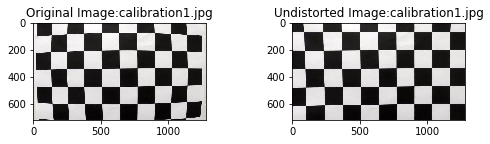

In [6]:
# Load the pickle file with camera matrix and distortion coefficients and check the undistorted image

test_img = mpimg.imread("camera_cal/calibration1.jpg")

picklefile = 'camera_calibration.p'
if (os.path.exists(picklefile) == False):
    print("Camera calibration not done. Calibrating now...")
    onetime_calibrate_camera()
else:
    print("Camera calibration already done")

f = open(picklefile, "rb")
pick = pickle.load(f)
mtx = pick['mtx']
dist = pick['dist']
out_img = undistort_image('calibration1.jpg',test_img, mtx, dist, False)
    

In [7]:
def color_grad_threshold(fname, img, is_pipeline, s_thresh, sobel_thresh):
    
    # Convert input image from RGB colorspace to HLS colorspace
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Apply Sobel operator in the x direction to get gradient in x direction
    sobel_x = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    
    # Find the absolute value of gradient
    abs_sobelx = np.absolute(sobel_x)
    
    # Convert the absolute value into 8 bits before applying thresholds
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Create a binary mask for gradient threshold
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1
    
    # Create a binary mask for saturation threshold
    s_binary = np.zeros_like(scaled_sobel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Create a combined binary mask
    combined_binary = np.zeros_like(scaled_sobel)
    combined_binary[(sobel_binary == 1) | (s_binary == 1)] = 1
    
    out_img = np.copy(combined_binary)
    
    # Plot original and undistorted image
    if not is_pipeline:
        f, (ax1,ax2) = plt.subplots(1,2)
        ax1.imshow(img)
        ax1.set_title('Undistorted Image:'+fname)
        ax2.imshow(out_img, cmap='gray')
        ax2.set_title('Threshold Mask Image:'+fname)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.5, wspace=0.5, hspace=0.9)
        mpimg.imsave('intermediate_output/'+fname+'_binary.png', out_img, cmap='gray')
    return out_img

In [8]:
def perspective_transform(fname, input_img, src_pts, dst_pts, is_pipeline):
    
    width = input_img.shape[1]
    height = input_img.shape[0]
    
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    
    warped = cv2.warpPerspective(input_img, M, (width, height), flags=cv2.INTER_LINEAR)
    
    out_img = np.copy(warped)
    
    # Plot binary and transformed image
    if not is_pipeline:
        f, (ax1,ax2) = plt.subplots(1,2)
        ax1.imshow(input_img, cmap = 'gray')
        ax1.set_title('Binary Image:'+fname)
        ax2.imshow(out_img, cmap='gray')
        ax2.set_title('Warped Image:'+fname)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.5, wspace=0.5, hspace=0.9)
        mpimg.imsave('intermediate_output/'+fname+'_warped.png', out_img, cmap='gray')
    return out_img

In [9]:
# Advanced Lane Detection Pipeline

def pipeline(fname, img, mtx, dist, is_pipeline):
    
    #Step 1: Undistort the image
    out_img = undistort_image(fname, img, mtx, dist, is_pipeline)
    
    #Step 2: Apply color and gradient thresholds
    binary_img = color_grad_threshold(fname, out_img, is_pipeline, s_thresh=(150, 255), sobel_thresh=(20, 100))
    
    #Step 3: Apply perspective transform
    height = binary_img.shape[0]
    width = binary_img.shape[1]
    src_pts= np.float32([[220,height-1],[1100, height-1],[580,470],[730,470]])
    dst_pts = np.float32([[300, height-1],[900, height-1],[300,0],[900,0]])
    warped_img = perspective_transform(fname, binary_img, src_pts, dst_pts, is_pipeline)
    

Running pipeline for straight_lines1.jpg
Running pipeline for test1.jpg
Running pipeline for test4.jpg
Running pipeline for test5.jpg
Running pipeline for test3.jpg
Running pipeline for straight_lines2.jpg
Running pipeline for test6.jpg


/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Running pipeline for test2.jpg


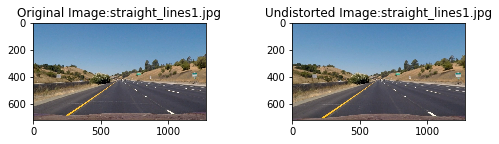

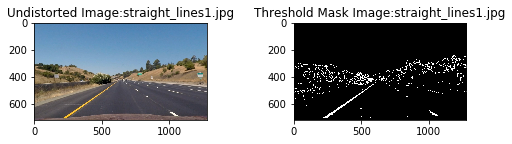

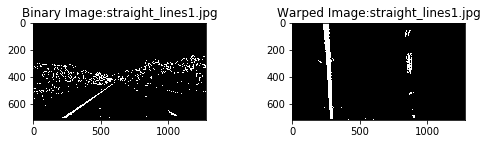

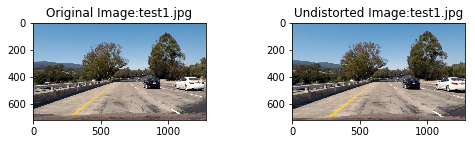

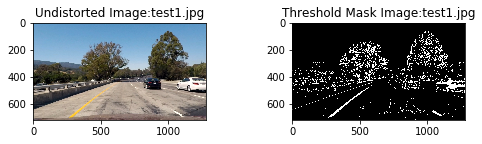

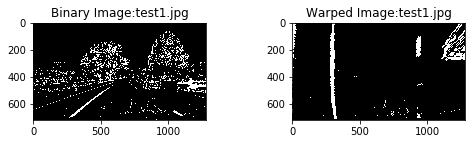

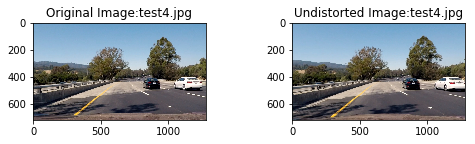

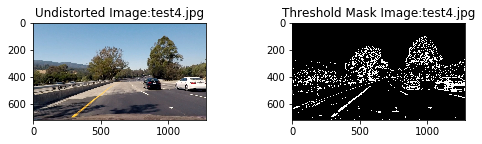

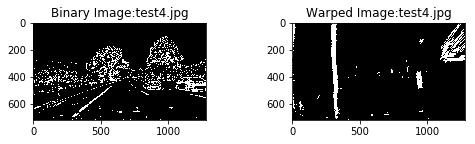

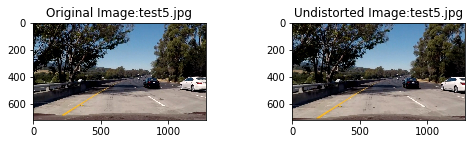

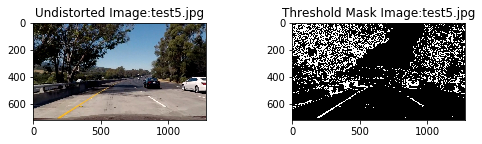

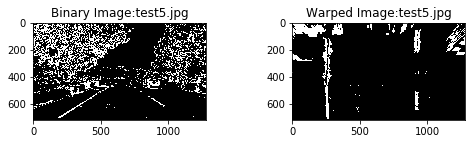

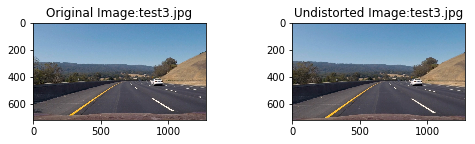

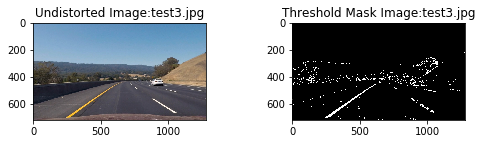

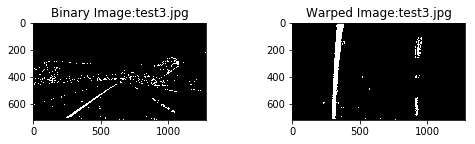

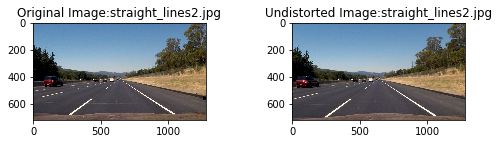

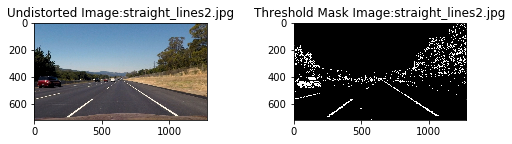

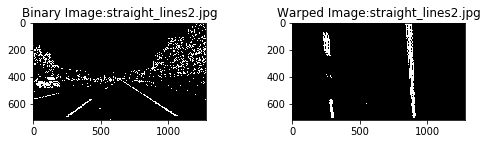

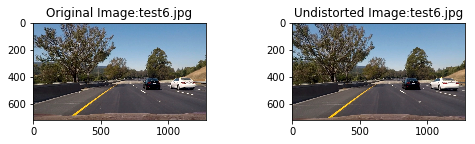

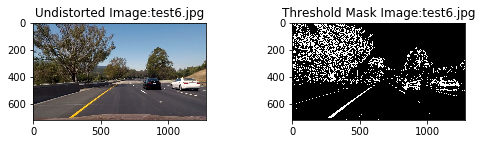

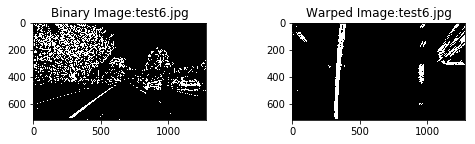

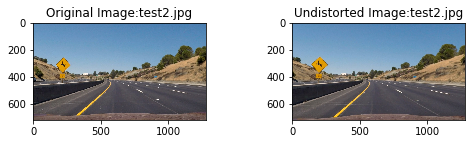

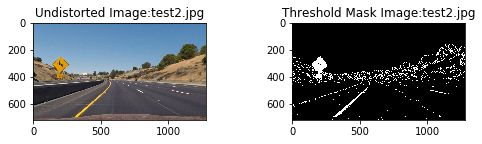

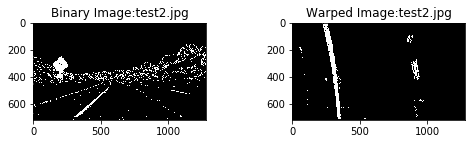

In [10]:
# Run the pipeline on the test images
imagedir = 'test_images'
files = os.listdir(imagedir)

for file in files:
    print("Running pipeline for " + file)
    
    input_filename = imagedir + '/' + file
    img = mpimg.imread(input_filename)
    
    pipeline(file, img, mtx, dist, False)